# Introduction

In this activity, we will be using machine learning to classify galaxies into three types (ellipticals, spirals or galactic mergers) based on their observed properties.

In the last activity you had a go at classifying galaxies by hand on the [Galaxy Zoo website](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/#/classify) which hopefully gave you some intuition for the dataset and how we can distinguish between the different types of galaxy.

For our machine learning experiments, we are using the crowd-classified classes from Galaxy Zoo as the training data for our automatic decision tree classifier.

We'll start by looking at how classification differs from regression. We will then implement some of the new features and parameters that we will use to reduce the dimensionality of the problem. We will also show you how to measure accuracy for classification problems, before extending our classifier to use random forests.

If you would like to try this on your own machine, the data set can be downloaded [here](https://groklearning-cdn.com/modules/jSAg5N3xrpKtvpDtCtMTGV/galaxy_catalogue.npy).

If you are interested in applying neural networks to the Galaxy Zoo data, we recommend you read the [blog post](https://blog.galaxyzoo.org/tag/neural-networks/) by Mike Walmsley and [the paper](https://arxiv.org/abs/1905.07424).

# Classification vs Regression

In classification, the predictions are from a fixed set of classes, whereas in regression the prediction typically corresponds to a continuum of possible values.

In regression, we measure accuracy by looking at the size of the differences between the predicted values and the actual values. In contrast, in classification problems a prediction can either be correct or incorrect. This makes measuring the accuracy of our model a lot simpler.

In terms of implementation using decision trees, there is very little difference between classification and regression. The only notable difference is that our targets are classes rather than real values. When calculating the accuracy, we check whether the predicted class matches as the actual class.

# A note on decision tree regression

In decision tree regression, the possible outputs are a finite set of values that correspond to the number of leaves/end points in the tree. Ideally we want as many points as possible to give a good approximation of the 'continuous' parameter space, whilst avoiding overfitting.

# The Galaxy Zoo data

In the last activity, you were a human classifier for the [Galaxy Zoo project](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/classify) and probably saw a wide range of galaxy types observed by the Sloan Digital Sky Survey. In this activity, we will limit our dataset to three types of galaxy: **spirals**, **ellipticals** and **mergers**.

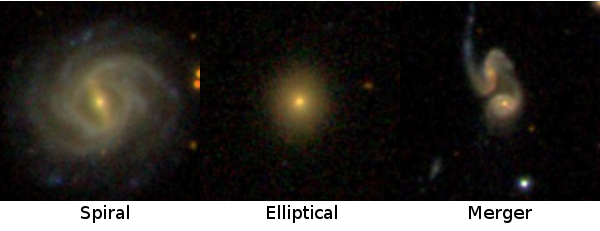

The galaxy catalogue we are using is a sample of galaxies where at least 20 human classifiers (such as yourself) have come to a consensus on the galaxy type.

Examples of spiral and elliptical galaxies were selected where there was a unanimous classification. Due to low sample numbers, we included merger examples where at least $80\%$ of human classifiers selected the merger class.

We need this high quality data to train our classifier.

# Deciding on features

Just like in the regression activities, we need to decide on a set of key features that represent our data.

While approaches exist that determine their own feature representation and use the raw pixel values as inputs, e.g. neural networks and deep learning, the majority of existing machine learning in astronomy requires an expert to design the feature set.

In this activity we will be using a set of features derived from fitting images according to known galaxy profiles.

Most of the features we use here are based on the five observed flux magnitudes from the Sloan Digital Sky Survey filters:

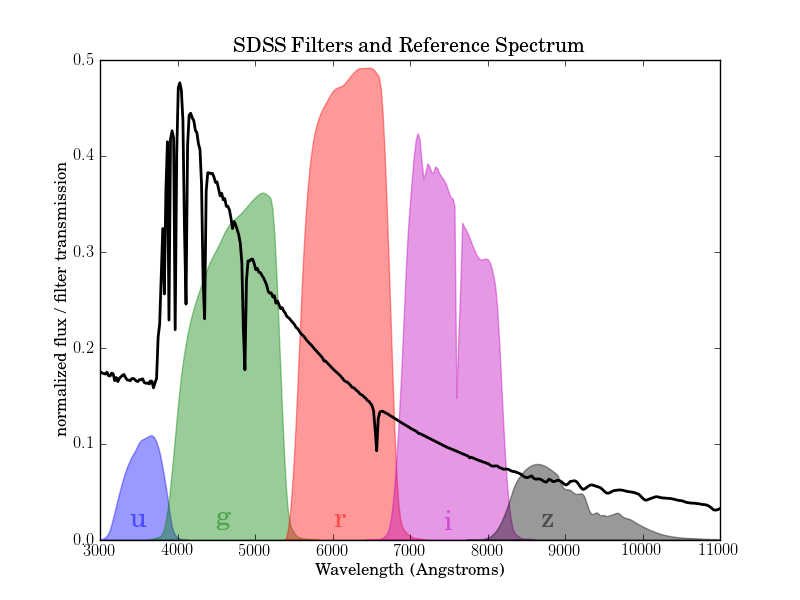

# Selecting features

The features that we will be using to do our galaxy classification are *colour index*, *adaptive moments*, *eccentricities* and *concentrations*. These features are provided as part of the SDSS catalogue.

We briefly describe these below. Further information how they are calculated can be found [here](https://skyserver.sdss.org/dr7/en/help/docs/algorithm.asp).

**Colour indices** are the same colours (u-g, g-r, r-i, and i-z) we used for regression. Studies of galaxy evolution tell us that spiral galaxies have younger star populations and therefore are 'bluer' (brighter at lower wavelengths). Elliptical galaxies have an older star population and are brighter at higher wavelengths ('redder').

**Eccentricity** approximates the shape of the galaxy by fitting an ellipse to its profile. Eccentricity is the ratio of the two axis (semi-major and semi-minor). The De Vaucouleurs model was used to attain these two axis. To simplify our experiments, we will use the median eccentricity across the 5 filters.

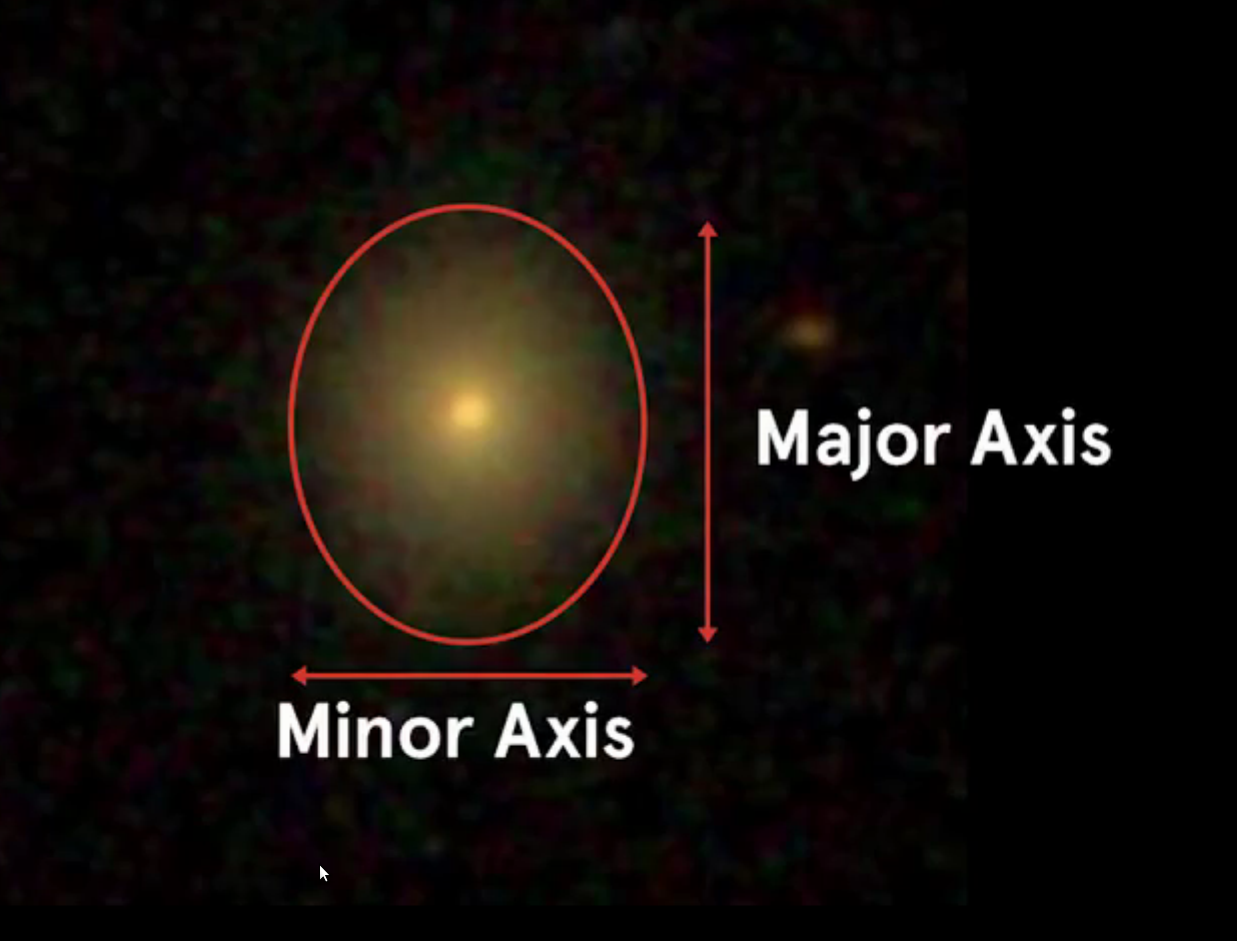

**Adaptive moments** are a measured quantity to describe the shape of a galaxy. They are used in image analysis to detect similar objects at different sizes and orientations. We use the fourth moment here for each band. You can read more about it [here](https://www.sdss4.org/dr16/algorithms/classify/#AdaptiveMoments).

**Concentration** is similar to the luminosity profile of the galaxy, which measures what proportion of a galaxy's total light is emitted within what radius. A simplified way to represent this is to take the ratio of the radii containing $50\%$ and $90\%$ of the Petrosian flux.

The Petrosian method allows us to compare the radial profiles of galaxies at different distances. If you are interested, you can [read more here](http://spiff.rit.edu/classes/phys443/lectures/gal_1/petro/petro.html) on the need for Petrosian approach.

For these experiments, we will define concentration as:

$\mbox{conc} = \frac{\mbox{petro}_{R50}}{\mbox{petro}_{R90}}$

We will use the concentration from the u, r and z bands.

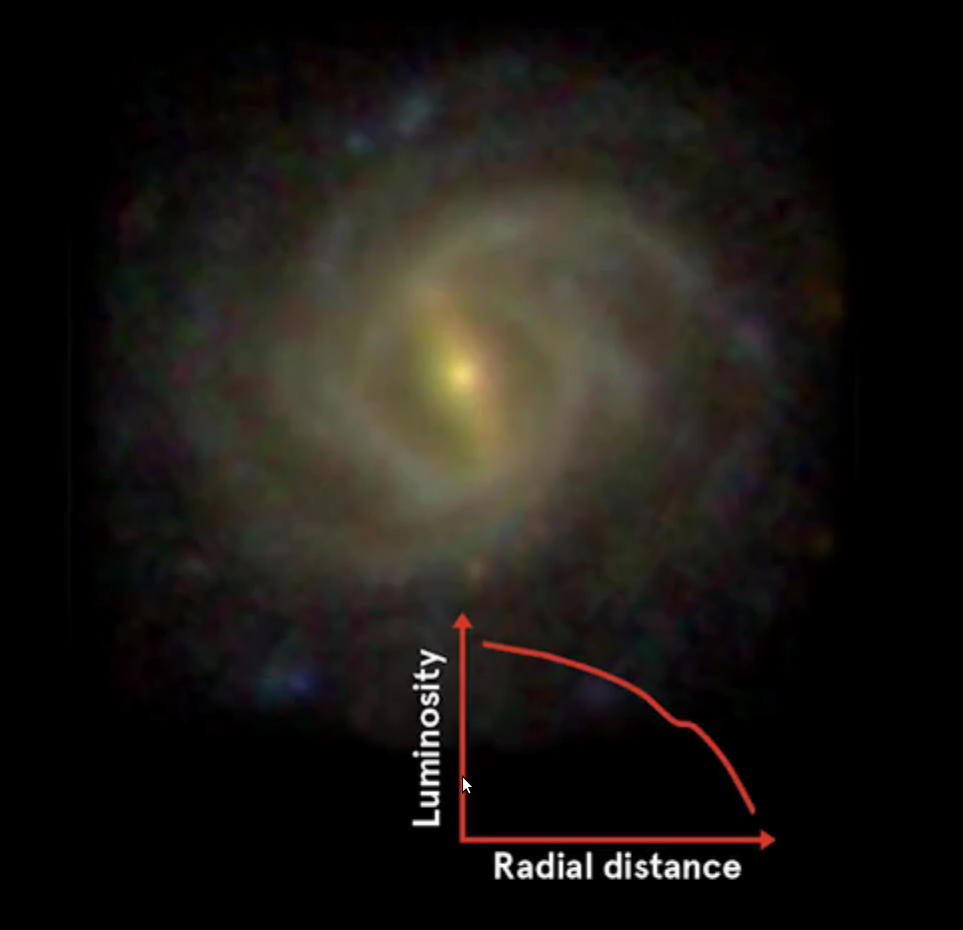

# Data description

We have extracted the SDSS and Galaxy Zoo data for 780 galaxies into a NumPy binary file. You can load the file using:

In [ ]:
import numpy as np
data = np.load('galaxy_catalogue.npy')

The data is a NumPy array of 780 records. Each record is a single galaxy. You can access the columns using field names. For example, to access the u-g colour filter for the first galaxy, you use:

In [ ]:
data[0]['u-g']

Here's a snippet that prints the field and values for the first galaxy:

In [ ]:
import numpy as np
data = np.load('galaxy_catalogue.npy')
for name, value in zip(data.dtype.names, data[0]):
  print('{:10} {:.6}'.format(name, value))

It shows the four colour features, median eccentricity, fourth adaptive moment of each filter, the Petrosian fluxes at a radius of 50% and 90% for the u, r and z filters, and finally the class:

### Feature Values and Classification

| Feature       | Value     |
|---------------|-----------|
| u-g           | 1.85765   |
| g-r           | 0.67158   |
| r-i           | 0.4231    |
| i-z           | 0.3061    |
| ecc           | 0.585428  |
| m4_u          | 2.25195   |
| m4_g          | 2.33985   |
| m4_r          | 2.38065   |
| m4_i          | 2.35974   |
| m4_z          | 2.39553   |
| petroR50_u    | 3.09512   |
| petroR50_r    | 3.81892   |
| petroR50_z    | 3.82623   |
| petroR90_u    | 5.17481   |
| petroR90_r    | 8.26301   |
| petroR90_z    | 11.4773   |
| **class**     | **merger** |


NumPy also allows you to access a field for all of the rows at once, i.e. a column, using the field's name:

In [ ]:
data['u-g']

# **Question: Splitting the train and test sets**

To start, we need to split the data into training and testing sets.

Your task is to implement the splitdata_train_test function. It takes a NumPy array and splits it into a training and testing NumPy array based on the specified training fraction. The function takes two arguments and should return two values:

# Arguments

* **data**: the NumPy array containing the galaxies in the form described in the previous slide;
* **fraction_training**: the fraction of the data to use for training. This will be a float between 0 and 1.

The number of training rows should be truncated if necessary. For example, with a fraction of 0.67 and our 780 galaxies, the number of training rows is 780*0.67 = 722.6, which should be truncated to 722 using int. The remaining rows should be used for testing.

# Return values

* **training_set**: the first value is a NumPy array training set;
* **testing_set**: the second value is a NumPy array testing set.

Using the supplied driver code, and our input data and a fraction of 0.7, the program should print the following values:

In [ ]:
Number data galaxies: 780
Train fraction: 0.7
Number of galaxies in training set: 546
Number of galaxies in testing set: 234

# **Good practice: randomize the dataset order**

You shouldn't assume that the data has already been shuffled. If you look at data['class'] you will see that the merger, elliptical and spiral examples appear together. Failing to shuffle the data will produce a very bad classifier! You can use:

In [ ]:
np.random.seed(0)
np.random.shuffle(data)

The first statement ensures the shuffle is the same for each experiment, so you get consistent results, the second shuffles the rows of the data array in place.

# ⌛Solution:

In [ ]:
import numpy as np

def splitdata_train_test(data, fraction_training):
  # complete this function
    np.random.seed(0)  # Ensure reproducibility
    np.random.shuffle(data)  # Shuffle the data in place

    # Determine the number of rows for the training set
    n_training = int(len(data) * fraction_training)

    # Split the data
    training_set = data[:n_training]
    testing_set = data[n_training:]

    return training_set, testing_set

if __name__ == "__main__":
  data = np.load('galaxy_catalogue.npy')

  # set the fraction of data which should be in the training set
  fraction_training = 0.7

  # split the data using your function
  training, testing = splitdata_train_test(data, fraction_training)

  # print the key values
  print('Number data galaxies:', len(data))
  print('Train fraction:', fraction_training)
  print('Number of galaxies in training set:', len(training))
  print('Number of galaxies in testing set:', len(testing))

# **Question: Generating features and targets**

Next, we generate features and targets for the decision tree.

The **generate_features_targets** function is mostly complete. However, you need to calculate the concentration values for the u, r and z filters.

Your task is to calculate the concentration for each filter from the 50% and 90% Petrosian radius measurements:

$\mbox{conc} = {\mbox{petro}_{R50}}/{\mbox{petro}_{R90}}$

As described earlier, data has the following fields:
- **Colours:** u-g, g-r, r-i, i-z
- **Eccentricity:** ecc
- **4th Adaptive Moments:** m4_u, m4_g, m4_r, m4_i, m4_z
- **50% Petrosian Radii:** petroR50_u, petroR50_r, petroR50_z
- **90% Petrosian Radii:** petroR90_u, petroR90_r, petroR90_z

# ⌛Solution:

In [ ]:
import numpy as np

def generate_features_targets(data):
  # complete the function by calculating the concentrations

  targets = data['class']

  features = np.empty(shape=(len(data), 13))
  features[:, 0] = data['u-g']
  features[:, 1] = data['g-r']
  features[:, 2] = data['r-i']
  features[:, 3] = data['i-z']
  features[:, 4] = data['ecc']
  features[:, 5] = data['m4_u']
  features[:, 6] = data['m4_g']
  features[:, 7] = data['m4_r']
  features[:, 8] = data['m4_i']
  features[:, 9] = data['m4_z']

  # fill the remaining 3 columns with concentrations in the u, r and z filters
  # concentration in u filter
  features[:, 10] = data['petroR50_u'] / data['petroR90_u']  # concentration in u filter
  features[:, 11] = data['petroR50_r'] / data['petroR90_r']  # concentration in r filter
  features[:, 12] = data['petroR50_z'] / data['petroR90_z']  # concentration in z filter

  return features, targets

if __name__ == "__main__":
  data = np.load('galaxy_catalogue.npy')

  features, targets = generate_features_targets(data)

  # Print the shape of each array to check the arrays are the correct dimensions.
  print("Features shape:", features.shape)
  print("Targets shape:", targets.shape)

# **Question: Train the decision tree classifier**

It is time to use the functions we wrote to split the data and generate the features, and then train a decision tree classifier.

Your task is complete the dtc_predict_actual function by following the Python comments. The purpose of the function is to perform a held out validation and return the predicted and actual classes for later comparison.

The function takes a single argument which is the full data set and should return two NumPy arrays containing the predicted and actual classes respectively.

You will also need to copy your solutions from the previous two questions into the spaces allocated.

# ⌛Solution:

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier


# copy your splitdata_train_test function here
def splitdata_train_test(data, fraction_training):
    "Splits the data into training and testing sets.

    np.random.seed(0)  # Ensure reproducibility
    np.random.shuffle(data)  # Shuffle the data in place

    n_training = int(len(data) * fraction_training)

    training_set = data[:n_training]
    testing_set = data[n_training:]

    return training_set, testing_set

# copy your generate_features_targets function here
def generate_features_targets(data):
    """
    Generate features and targets for decision tree classification.

    Args:
    - data: NumPy array containing galaxy data.

    Returns:
    - features: NumPy array containing the features (shape: [n_samples, 13]).
    - targets: NumPy array containing the target classes.
    """
    targets = data['class']

    features = np.empty(shape=(len(data), 13))
    features[:, 0] = data['u-g']
    features[:, 1] = data['g-r']
    features[:, 2] = data['r-i']
    features[:, 3] = data['i-z']
    features[:, 4] = data['ecc']
    features[:, 5] = data['m4_u']
    features[:, 6] = data['m4_g']
    features[:, 7] = data['m4_r']
    features[:, 8] = data['m4_i']
    features[:, 9] = data['m4_z']
    features[:, 10] = data['petroR50_u'] / data['petroR90_u']
    features[:, 11] = data['petroR50_r'] / data['petroR90_r']
    features[:, 12] = data['petroR50_z'] / data['petroR90_z']

    return features, targets

# complete this function by splitting the data set and training a decision tree classifier
def dtc_predict_actual(data):
    """
    Perform held-out validation using a decision tree classifier and return predictions and actual classes.

    Args:
    - data: NumPy array containing galaxy data.

    Returns:
    - predicted_class: NumPy array containing predicted classes.
    - actual_class: NumPy array containing actual classes.
    """
    # Split the data into training and testing sets
    training_set, testing_set = splitdata_train_test(data, fraction_training=0.7)

    # Generate features and targets for training and testing sets
    train_features, train_targets = generate_features_targets(training_set)
    test_features, test_targets = generate_features_targets(testing_set)

    # Instantiate and train a decision tree classifier
    dtc = DecisionTreeClassifier()
    dtc.fit(train_features, train_targets)

    # Get predictions for the test features
    predicted_class = dtc.predict(test_features)

    # Return predictions and actual test targets
    return predicted_class, test_targets


if __name__ == '__main__':
  data = np.load('galaxy_catalogue.npy')

  predicted_class, actual_class = dtc_predict_actual(data)

  # Print some of the initial results
  print("Some initial results...\n   predicted,  actual")
  for i in range(10):
    print("{}. {}, {}".format(i, predicted_class[i], actual_class[i]))


# Accuracy and model score

The accuracy of classification problems is a lot simpler to calculate than for regression problems. The simplest measure is the fraction of objects that are correctly classified. That is

$\mbox{accuracy} = \frac{\mbox{# correct predictions}}{\mbox{# predictions}}$

$\mbox{accuracy} = \frac{\sum_{i=1}^{n} \mbox{predicted}_i = \mbox{actual}_i}{n}$

The accuracy measure is often called the model score. While the way of calculating the score can vary depending on the model, the accuracy is the most common for classification problems.

Note: **sklearn** has methods to get the model score. Most models will have a score method which in the case of the decision tree classifier uses the above formula. The **cross_val_score** function in the **model_selectio**n module can be used to get $k$ cross validated scores.

# Confusion matrices

In addition to an overall accuracy score, we'd also like to know where our model is going wrong. For example, were the incorrectly classified mergers mis-classified as spirals or ellipticals? To answer this type of question we use a *confusion matrix*. An example confusion matrix for our problem is shown below:

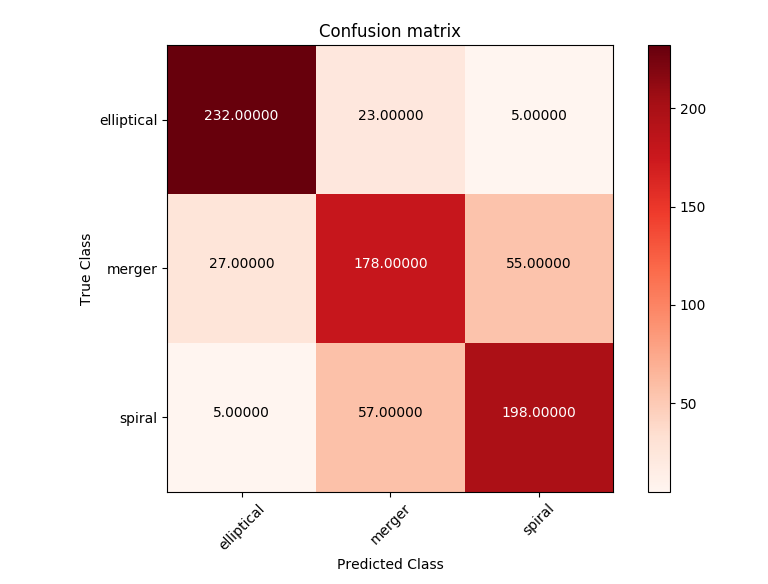

The x axis represents the predicted classes and the y axis represents the correct classes. The value in each cell is the number of examples with those predicted and actual classes. Correctly classified objects are along the diagonal of the matrix.

So of the 260 actual spirals (correct class) in the data set, 198 are correctly predicted as spirals, 5 are incorrectly predicted as ellipticals and 57 are incorrectly predicted as mergers.

The sum along each row or column can be used to get the totals of true and predicted classes. So for example, by summing each of the rows we can confirm that there are 260 mergers, 260 spirals and 260 ellipticals in the data set.

# **Question: Accuracy in classification**

Your task is to complete the calculate_accuracy function. The function should calculate the accuracy: the fraction of predictions that are correct (i.e. the model score):

$\mbox{accuracy} = \frac{\mbox{# correct predictions}}{\mbox{# predictions}}$

The function takes two arguments;

- **predicted**: an array of the predicted class for each galaxy.
- **actual**: an array of the actual class for each galaxy.

The return value should be a float (between 0 and 1).

# ⌛Solution:

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from support_functions import plot_confusion_matrix, generate_features_targets

# Implement the following function
def calculate_accuracy(predicted, actual):
# Count the number of correct predictions
    correct_predictions = np.sum(predicted == actual)

    # Calculate accuracy as the fraction of correct predictions
    accuracy = correct_predictions / len(actual)

    return accuracy

if __name__ == "__main__":
  data = np.load('galaxy_catalogue.npy')

  # split the data
  features, targets = generate_features_targets(data)

  # train the model to get predicted and actual classes
  dtc = DecisionTreeClassifier()
  predicted = cross_val_predict(dtc, features, targets, cv=10)

  # calculate the model score using your function
  model_score = calculate_accuracy(predicted, targets)
  print("Our accuracy score:", model_score)

  # calculate the models confusion matrix using sklearns confusion_matrix function
  class_labels = list(set(targets))
  model_cm = confusion_matrix(y_true=targets, y_pred=predicted, labels=class_labels)

  # Plot the confusion matrix using the provided functions.
  plt.figure()
  plot_confusion_matrix(model_cm, classes=class_labels, normalize=False)
  plt.show()

where the support functions are:

In [ ]:
import numpy as np
import itertools
from matplotlib import pyplot as plt

def generate_features_targets(data):
    output_targets = np.empty(shape=(len(data)), dtype='<U20')
    output_targets[:] = data['class']

    input_features = np.empty(shape=(len(data), 13))
    input_features[:, 0] = data['u-g']
    input_features[:, 1] = data['g-r']
    input_features[:, 2] = data['r-i']
    input_features[:, 3] = data['i-z']
    input_features[:, 4] = data['ecc']
    input_features[:, 5] = data['m4_u']
    input_features[:, 6] = data['m4_g']
    input_features[:, 7] = data['m4_r']
    input_features[:, 8] = data['m4_i']
    input_features[:, 9] = data['m4_z']
    input_features[:, 10] = data['petroR50_u'] / data['petroR90_u']
    input_features[:, 11] = data['petroR50_r'] / data['petroR90_r']
    input_features[:, 12] = data['petroR50_z'] / data['petroR90_z']

    return input_features, output_targets

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')

# Random forests classification

So far we have used a single decision tree model. However, we can improve the accuracy of our classification by using a collection (or ensemble) of trees as known as a *random forest*.

A random forest is a collection of decision trees that have each been independently trained using different subsets of the training data and/or different combinations of features in those subsets.

When making a prediction, every tree in the forest gives its own prediction and the most common classification is taken as the overall forest prediction (in regression the mean prediction is used).

# Advantages of random forest classifiers

Random forests help to mitigate overfitting in decision trees.

**Training data** is spread across decision trees. The subsets are created by taking random samples with replacement. This means that a given data point can be used in several subsets. (This is different from the subsets used in cross validation where each data point belongs to one subset).

**Individual trees** are trained *with* different subsets of features. So in our current problem, one tree might be trained using eccentricity and another using concentration and the 4th adaptive moment. By using different combinations of input features you create expert trees that are can better identify classes by a given feature.

**The sklearn random forest only uses the first form of sampling.**

# **Question: Random Forest**

Your task here is to complete the **rf_predict_actual** function. It returns the predicted and actual classes for our galaxies using a random forest 10-fold with cross validation.

You should use the **RandomForestClassifier** class from the **sklearn.ensemble** module. It can be instantiated with:

In [ ]:
rfc = RandomForestClassifier(n_estimators=n_estimators)

**n_estimators** is the the number of decision trees in the forest.

**rf_predict_actual** takes two arguments: the data used throughout this activity and the number of estimators (n_estimators) to be used in the random forest.

The function should return two NumPy arrays containing the predicted and actual classes respectively.

You can copy and paste the functions from previous questions. However, we have provided the **generate_features_targets** function in the support library.

Use the **cross_val_predict** function from the **model_selection** module as we did in the last question.

You can read its documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html). This approach allows us to get a prediction for every galaxy in the data set through cross validation. It also means that we don't need to manage the training and test sets.

# ⌛Solution:

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from support_functions import generate_features_targets, plot_confusion_matrix, calculate_accuracy

# complete this function to get predictions from a random forest classifier
def rf_predict_actual(data, n_estimators):
# Generate the features and targets
    features, targets = generate_features_targets(data)

    # Instantiate a Random Forest Classifier with n_estimators
    rfc = RandomForestClassifier(n_estimators=n_estimators)

    # Get predictions using 10-fold cross-validation
    predicted = cross_val_predict(rfc, features, targets, cv=10)

    # Return the predictions and actual classes
    return predicted, targets

if __name__ == "__main__":
  data = np.load('galaxy_catalogue.npy')

  # get the predicted and actual classes
  number_estimators = 50              # Number of trees
  predicted, actual = rf_predict_actual(data, number_estimators)

  # calculate the model score using your function
  accuracy = calculate_accuracy(predicted, actual)
  print("Accuracy score:", accuracy)

  # calculate the models confusion matrix using sklearns confusion_matrix function
  class_labels = list(set(actual))
  model_cm = confusion_matrix(y_true=actual, y_pred=predicted, labels=class_labels)

  # plot the confusion matrix using the provided functions.
  plt.figure()
  plot_confusion_matrix(model_cm, classes=class_labels, normalize=False)
  plt.show()

where the support functions are:

In [ ]:
import numpy as np
import itertools
from matplotlib import pyplot as plt

def calculate_accuracy(predicted_classes, actual_classes, ):
    return sum(actual_classes[:] == predicted_classes[:]) / len(actual_classes)

def generate_features_targets(data):
    output_targets = np.empty(shape=(len(data)), dtype='<U20')
    output_targets[:] = data['class']

    input_features = np.empty(shape=(len(data), 13))
    input_features[:, 0] = data['u-g']
    input_features[:, 1] = data['g-r']
    input_features[:, 2] = data['r-i']
    input_features[:, 3] = data['i-z']
    input_features[:, 4] = data['ecc']
    input_features[:, 5] = data['m4_u']
    input_features[:, 6] = data['m4_g']
    input_features[:, 7] = data['m4_r']
    input_features[:, 8] = data['m4_i']
    input_features[:, 9] = data['m4_z']
    input_features[:, 10] = data['petroR50_u'] / data['petroR90_u']
    input_features[:, 11] = data['petroR50_r'] / data['petroR90_r']
    input_features[:, 12] = data['petroR50_z'] / data['petroR90_z']

    return input_features, output_targets

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')

# Results discussion

Did the random forest improve the accuracy of the model? The answer is yes – we see a substantial increase in accuracy. When we look at the 10-fold cross validation results, we see that the random forest systematically out performs a single decision tree:

|                                 | Random Forest | Decision Tree |
|---------------------------------|---------------|---------------|
| Median score                    | 0.865         | 0.775         |
| Mean score                      | 0.867         | 0.792         |
| Standard deviation of scores    | 0.036         | 0.035         |


The random forest is around $\approx6-7\%$ more accurate than a standard decision tree.

Below is a side by side comparision of the confusion matrices from our galaxy catalogues. The first showing the results for the random forest classifier and the second for the decision tree classifier. There are improvements accross the board with the biggest improvement (percentage) being between ellipticals and spirals.

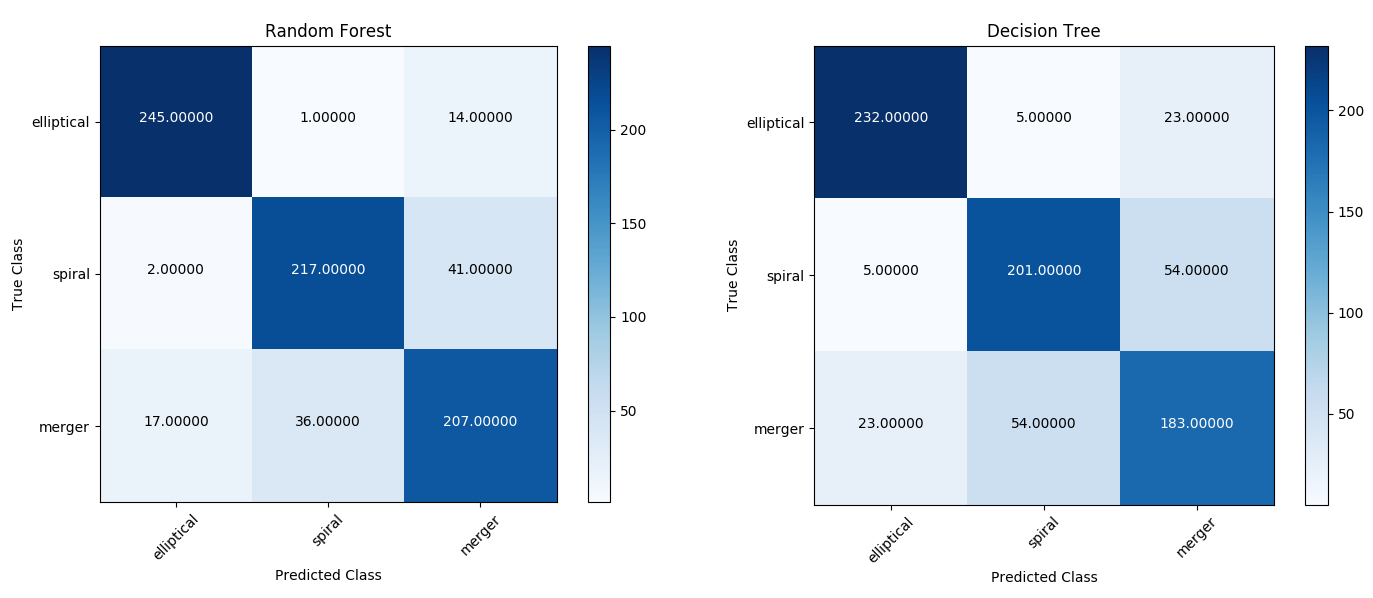

# Conclusions

In this activity we have used decision tree classifiers to identify a galaxies type by a selection of derived features (e.g. eccentricity and concentration).

We have learnt that asessing the models performance is a lot simpler with classification than it is with regression.

Confusion matrices can be a useful tool to help understand where our model is over and under preforming with respect to each class.

We started out with the goal of using decision trees to classify galaxies as one of three types. We found that we were able to achieve an accuracy of around 80% using decision trees which is very good when you consider the statistical accuracy of a random selection is 33% and the naive approach using only pixel values yielded ~64%.

We were able to improve on the accuracy of the decision tree classifier by using a selection of them in ensemble learning with a random forest.